# Are Severity Scores Biased?

Questions? Irene  Chen (iychen@mit.edu), 3/3/17

Inspired by the [Propublica investigation](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) of bias in predictive algorithms used in criminal justice, this notebook aims to explore whether bias exists in the mortality scores commonly used in ICUs.  

Requirements:

* MIMIC-III in a PostgreSQL database
* Severity scores calculated according to [mimic-code](https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores)
* Python packages installable with: 
    * `pip install numpy pandas matplotlib psycopg2 jupyter`
    
First, as always, we open a connection to a local copy of the database. If you don't have a local copy of the database in PostgreSQL, follow the tutorial online (http://mimic.physionet.org) to install one.

# Table of Contents

[Severity Scores](#SeverityScores)

In [171]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

from sklearn.metrics import roc_curve, auc


# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'irenechen'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

# Severity Scores

Severity scores are often used for the critically ill in order to prioritize care. [More info](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/ceaccp/8/5/10.1093/bjaceaccp/mkn033/2/mkn033.pdf?Expires=1488904187&Signature=aO-NDrw12wlg6v8D5N4vAGTiLCesNVwLLKkMBlvT3SbnUH2vKO4fLSj8EofbXAp5X1KGA1te1waWi3jLm1nSWrmg9MhGklC-tgT~ycMICiaGjerMCVA3l6~76-lYL6JHNuNmWEjIujVpNLxRsJPZsgx7m8zvGf9gxkxKEDS7srpnfV9EcUPndffNWQnWQJw0cZpRNvcDFDlsSKN62L5LlhLoxQWMJAO86EB~j27qzj6UULFSM1nLcV-cjucs60VqzzyboDQPw7c0zECV5dhKO~EA7~umHQoWoxjS2hh3fseiuVqGBy0UxGvcdhsgaMIw5wnRmS7pFgJBb14cmj8z~w__&Key-Pair-Id=APKAIUCZBIA4LVPAVW3Q)

In addition to the MIMIC-III dataset, we create the following tables from the mimic-code repo for convenience and readability of querying.

[Severity scores](https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores)
* oasis.sql
* sofa.sql
* saps.sql
* sapsii.sql
* apsiii.sql
* lods.sql

[Demographics](https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics)
* icustay_detail
* heightweight

## Data Selection

We draw heavily from the [Cohort Selection Tutorial](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb) and the [Querying MIMIC-III Tutorial](https://mimic.physionet.org/tutorials/intro-to-mimic-iii/). 

Our primary method of separating the data will be age, defined as neonatal (< 15 years old), adult (>15, < 89), and eldery (>89).

The goal is to determine whether or not mortality scores are equally accurate across different demographic attributes, including:
* genotypical sex
* age
* ethnicity

Note that other demographics (socioeconomic level) would be cool to examine but are not included in the MIMIC-III dataset.

After our first cut of data, we may also wish to explore the following:
* ICU length
* types of service

Note that as MIMIC-III is primarily an intensive care unit (ICU) database, the focus will be on patients admitted to and discharged from the ICU. That is, rather than selecting our cohort based off the individual patient (identified by `subject_id` in the database), we will usually want to select our cohort based off the ICU stay (identified by `icustay_id`). 

Caveats below. At this time, we do not consider:
* multiple admissions
* transfers between services
* specifics of severity tests beyond aggregate scores
* pre-ICU length of stay
* type of caregiver

In [172]:
query = query_schema + """
SELECT 
    ie.subject_id, ie.hadm_id, ie.icustay_id,
    ie.intime, ie.outtime, adm.deathtime,
    pat.gender, adm.ethnicity,
    ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) AS age,
    ROUND((cast(ie.intime as date) - cast(adm.admittime as date))/365.242, 2) AS preiculos,
    CASE
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 1
            THEN 'neonate'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 14
            THEN 'middle'
        -- all ages > 89 in the database were replaced with 300
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) > 100
            THEN '>89'
        ELSE 'adult'
        END AS ICUSTAY_AGE_GROUP,
    CASE
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 1
            THEN 'neonate'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 14
            THEN 'middle'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 20
            THEN '10s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 30
            THEN '20s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 40
            THEN '30s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 50
            THEN '40s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 60
            THEN '50s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 70
            THEN '60s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 80
            THEN '70s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 90
            THEN '80s'
        -- all ages > 89 in the database were replaced with 300
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) > 100
            THEN '>89'
        ELSE 'adult'
        END AS age_group,
    CASE
        WHEN adm.discharge_location = 'DEAD/EXPIRED' THEN 'Y'
        ELSE 'N'
        END AS hospital_expire_flag,
    CASE
        WHEN adm.deathtime BETWEEN ie.intime and ie.outtime
            THEN 'Y'
        -- sometimes there are typographical errors in the death date, so check before intime
        WHEN adm.deathtime <= ie.intime
            THEN 'Y'
        WHEN adm.dischtime <= ie.outtime
            AND adm.discharge_location = 'DEAD/EXPIRED'
            THEN 'Y'
        ELSE 'N'
        END AS ICUSTAY_EXPIRE_FLAG,
    adm.admission_type,
    os.oasis, sf.sofa, sp.saps, spii.sapsii, apsiii.apsiii, lods.lods,
    2.2 * height_first as h_first, 
    2.2 * height_min as h_min, 
    2.2 * height_max as h_max, 
    0.394 * weight_first as w_first, 
    0.394 * weight_min as w_min, 
    0.394 * weight_max as w_max,
    CASE 
        WHEN 0.394 * hw.weight_max < 45 THEN '<45'
        WHEN 0.394 * hw.weight_max < 50 THEN '45-50'
        WHEN 0.394 * hw.weight_max < 55 THEN '50-55'
        WHEN 0.394 * hw.weight_max < 60 THEN '55-60'
        WHEN 0.394 * hw.weight_max < 65 THEN '60-65'
        WHEN 0.394 * hw.weight_max < 70 THEN '65-70'
        WHEN 0.394 * hw.weight_max < 75 THEN '70-75'
        WHEN 0.394 * hw.weight_max < 80 THEN '75-80'
        WHEN 0.394 * hw.weight_max < 85 THEN '80-85'
        ELSE '85+'
    END as height_group,
    weight_first / (height_first * height_first/10000) as bmi,
    CASE
        WHEN weight_first / (height_first * height_first / 10000) < 18.5 THEN 'underweight'
        WHEN weight_first / (height_first * height_first / 10000) < 25 THEN 'normal'
        WHEN weight_first / (height_first * height_first / 10000) < 30 THEN 'overweight'
        WHEN weight_first / (height_first * height_first / 10000) > 30 THEN 'obese'
        ELSE 'error'
    END as bmi_group
FROM icustays ie
INNER JOIN patients pat
ON ie.subject_id = pat.subject_id
INNER JOIN admissions adm
ON ie.hadm_id = adm.hadm_id and ie.subject_id = adm.subject_id
INNER JOIN oasis os
on ie.hadm_id = os.hadm_id and ie.subject_id = os.subject_id and ie.icustay_id = os.icustay_id
INNER JOIN sofa sf
on ie.hadm_id = sf.hadm_id and ie.subject_id = sf.subject_id and ie.icustay_id = sf.icustay_id
INNER JOIN saps sp
on ie.hadm_id = sp.hadm_id and ie.subject_id = sp.subject_id and ie.icustay_id = sp.icustay_id
INNER JOIN sapsii spii
on ie.hadm_id = spii.hadm_id and ie.subject_id = spii.subject_id and ie.icustay_id = spii.icustay_id
INNER JOIN apsiii apsiii
on ie.hadm_id = apsiii.hadm_id and ie.subject_id = apsiii.subject_id and ie.icustay_id = apsiii.icustay_id
INNER JOIN lods lods
on ie.hadm_id = lods.hadm_id and ie.subject_id = lods.subject_id and ie.icustay_id = lods.icustay_id
INNER JOIN heightweight hw
on ie.subject_id = hw.subject_id and ie.icustay_id = hw.icustay_id
INNER JOIN diagnoses_icd diag
on ie.subject_id = diag.subject_id and ie.hadm_id = diag.hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,deathtime,gender,ethnicity,age,preiculos,...,lods,h_first,h_min,h_max,w_first,w_min,w_max,height_group,bmi,bmi_group
0,27513,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,NaT,M,WHITE,48.29,0.00,...,3,NaN,NaN,NaN,30.53500,30.33800,31.40180,<45,NaN,error
1,17020,158088,200020,2174-05-14 00:32:29,2174-05-14 08:23:35,NaT,F,WHITE,0.00,0.00,...,0,NaN,NaN,NaN,1.74542,0.13790,1.74542,<45,NaN,error
2,46489,152416,200035,2156-10-09 13:56:42,2156-10-10 18:02:07,2156-10-23 04:00:00,M,BLACK/AFRICAN AMERICAN,30.67,0.01,...,1,NaN,NaN,NaN,37.62700,37.62700,37.62700,<45,NaN,error
3,9960,159243,200036,2181-08-26 16:38:25,2181-08-29 16:28:48,NaT,M,WHITE,74.93,0.00,...,10,NaN,NaN,NaN,30.92900,30.92900,31.32300,<45,NaN,error
4,21695,150812,200037,2141-08-07 09:29:48,2141-08-25 17:16:56,NaT,F,WHITE,0.00,0.00,...,1,99.0,97.9,99.0,0.71314,0.01182,0.84316,<45,8.938272,underweight


In [185]:
query = query_schema + """
SELECT 
    ie.subject_id, ie.hadm_id, ie.icustay_id,
    ie.intime, ie.outtime, adm.deathtime,
    pat.gender, adm.ethnicity,
    ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) AS age,
    ROUND((cast(ie.intime as date) - cast(adm.admittime as date))/365.242, 2) AS preiculos,
    CASE
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 1
            THEN 'neonate'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 14
            THEN 'middle'
        -- all ages > 89 in the database were replaced with 300
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) > 100
            THEN '>89'
        ELSE 'adult'
        END AS ICUSTAY_AGE_GROUP,
    CASE
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 1
            THEN 'neonate'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 14
            THEN 'middle'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 20
            THEN '10s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 30
            THEN '20s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 40
            THEN '30s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 50
            THEN '40s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 60
            THEN '50s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 70
            THEN '60s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 80
            THEN '70s'
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 90
            THEN '80s'
        -- all ages > 89 in the database were replaced with 300
        WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) > 100
            THEN '>89'
        ELSE 'adult'
        END AS age_group,
    CASE
        WHEN adm.discharge_location = 'DEAD/EXPIRED' THEN 'Y'
        ELSE 'N'
        END AS hospital_expire_flag,
    CASE
        WHEN adm.deathtime BETWEEN ie.intime and ie.outtime
            THEN 'Y'
        -- sometimes there are typographical errors in the death date, so check before intime
        WHEN adm.deathtime <= ie.intime
            THEN 'Y'
        WHEN adm.dischtime <= ie.outtime
            AND adm.discharge_location = 'DEAD/EXPIRED'
            THEN 'Y'
        ELSE 'N'
        END AS ICUSTAY_EXPIRE_FLAG,
    adm.admission_type,
    os.oasis, sf.sofa, sp.saps, spii.sapsii, apsiii.apsiii, lods.lods,
    2.2 * height_first as h_first, 
    2.2 * height_min as h_min, 
    2.2 * height_max as h_max, 
    0.394 * weight_first as w_first, 
    0.394 * weight_min as w_min, 
    0.394 * weight_max as w_max,
    CASE 
        WHEN 0.394 * hw.weight_max < 45 THEN '<45'
        WHEN 0.394 * hw.weight_max < 50 THEN '45-50'
        WHEN 0.394 * hw.weight_max < 55 THEN '50-55'
        WHEN 0.394 * hw.weight_max < 60 THEN '55-60'
        WHEN 0.394 * hw.weight_max < 65 THEN '60-65'
        WHEN 0.394 * hw.weight_max < 70 THEN '65-70'
        WHEN 0.394 * hw.weight_max < 75 THEN '70-75'
        WHEN 0.394 * hw.weight_max < 80 THEN '75-80'
        WHEN 0.394 * hw.weight_max < 85 THEN '80-85'
        ELSE '85+'
    END as height_group,
    weight_first / (height_first * height_first/10000) as bmi,
    CASE
        WHEN weight_first / (height_first * height_first / 10000) < 18.5 THEN 'underweight'
        WHEN weight_first / (height_first * height_first / 10000) < 25 THEN 'normal'
        WHEN weight_first / (height_first * height_first / 10000) < 30 THEN 'overweight'
        WHEN weight_first / (height_first * height_first / 10000) > 30 THEN 'obese'
        ELSE 'error'
    END as bmi_group,
    diag.icd9_code
FROM icustays ie
INNER JOIN patients pat
ON ie.subject_id = pat.subject_id
INNER JOIN admissions adm
ON ie.hadm_id = adm.hadm_id and ie.subject_id = adm.subject_id
INNER JOIN oasis os
on ie.hadm_id = os.hadm_id and ie.subject_id = os.subject_id and ie.icustay_id = os.icustay_id
INNER JOIN sofa sf
on ie.hadm_id = sf.hadm_id and ie.subject_id = sf.subject_id and ie.icustay_id = sf.icustay_id
INNER JOIN saps sp
on ie.hadm_id = sp.hadm_id and ie.subject_id = sp.subject_id and ie.icustay_id = sp.icustay_id
INNER JOIN sapsii spii
on ie.hadm_id = spii.hadm_id and ie.subject_id = spii.subject_id and ie.icustay_id = spii.icustay_id
INNER JOIN apsiii apsiii
on ie.hadm_id = apsiii.hadm_id and ie.subject_id = apsiii.subject_id and ie.icustay_id = apsiii.icustay_id
INNER JOIN lods lods
on ie.hadm_id = lods.hadm_id and ie.subject_id = lods.subject_id and ie.icustay_id = lods.icustay_id
INNER JOIN heightweight hw
on ie.subject_id = hw.subject_id and ie.icustay_id = hw.icustay_id
INNER JOIN diagnoses_icd diag
on ie.subject_id = diag.subject_id and ie.hadm_id = diag.hadm_id;
"""
diag_df = pd.read_sql_query(query, con)
diag_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,deathtime,gender,ethnicity,age,preiculos,...,h_first,h_min,h_max,w_first,w_min,w_max,height_group,bmi,bmi_group,icd9_code
0,27513,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,None,M,WHITE,48.29,0.0,...,NaN,NaN,NaN,30.535,30.338,31.4018,<45,NaN,error,0389
1,27513,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,None,M,WHITE,48.29,0.0,...,NaN,NaN,NaN,30.535,30.338,31.4018,<45,NaN,error,70709
2,27513,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,None,M,WHITE,48.29,0.0,...,NaN,NaN,NaN,30.535,30.338,31.4018,<45,NaN,error,5761
3,27513,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,None,M,WHITE,48.29,0.0,...,NaN,NaN,NaN,30.535,30.338,31.4018,<45,NaN,error,9974
4,27513,163557,200003,2199-08-02 19:50:04,2199-08-08 17:09:18,None,M,WHITE,48.29,0.0,...,NaN,NaN,NaN,30.535,30.338,31.4018,<45,NaN,error,99591


In [173]:
print df.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'intime', u'outtime',
       u'deathtime', u'gender', u'ethnicity', u'age', u'preiculos',
       u'icustay_age_group', u'age_group', u'hospital_expire_flag',
       u'icustay_expire_flag', u'admission_type', u'oasis', u'sofa', u'saps',
       u'sapsii', u'apsiii', u'lods', u'h_first', u'h_min', u'h_max',
       u'w_first', u'w_min', u'w_max', u'height_group', u'bmi', u'bmi_group'],
      dtype='object')


In [174]:
# Why are there different number of rows, patients, and hospital admitances?
print 'Total rows: %d' % len(df)
print 'Unique patients: %d' % len(np.unique(df.subject_id))
print 'Unique admissions: %d' % len(np.unique(df.hadm_id))

Total rows: 52898
Unique patients: 41135
Unique admissions: 50731


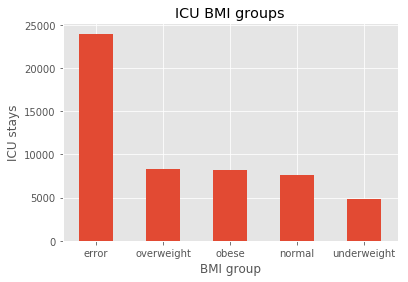

In [193]:
df['bmi_group'].value_counts().plot(kind='bar')
plt.xticks(rotation='0')
plt.ylabel('ICU stays')
plt.xlabel('BMI group')
plt.title('ICU BMI groups')
plt.show()

In [176]:
rlst = ['ASIAN', 'BLACK', 'HISPANIC', 'WHITE']

def get_racial_group(s):
    pred_race = None
    for r in rlst:
        if r in s:
            return r
    if not pred_race:
        return 'OTHER'

df['eth_group'] = df['ethnicity'].apply(get_racial_group)

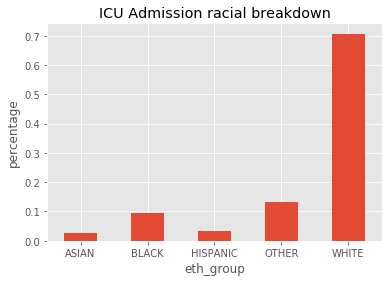

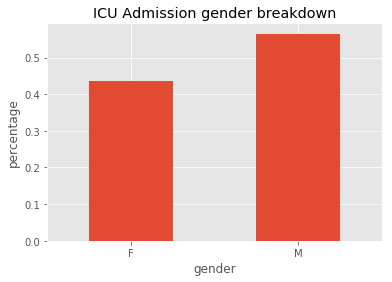

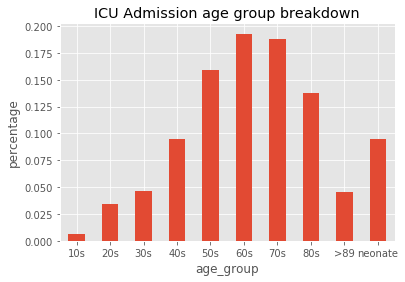

In [177]:
# RACIAL breakdown
df.groupby('eth_group').count().apply(lambda x: x / len(df))['subject_id'].plot(kind='bar')
plt.title('ICU Admission racial breakdown')
plt.ylabel('percentage')
plt.xticks(rotation='0')
plt.show()

# GENDER
df.groupby('gender').count().apply(lambda x: x / len(df))['subject_id'].plot(kind='bar')
plt.title('ICU Admission gender breakdown')
plt.ylabel('percentage')
plt.xticks(rotation='0')
plt.show()

# GENDER
df.groupby('age_group').count().apply(lambda x: x / len(df))['subject_id'].plot(kind='bar')
plt.title('ICU Admission age group breakdown')
plt.ylabel('percentage')
plt.xticks(rotation='0')
plt.show()

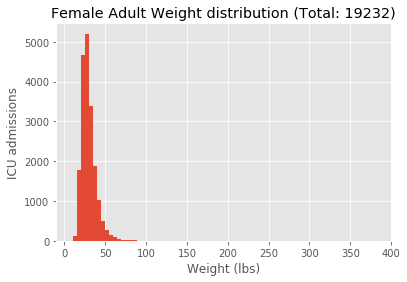

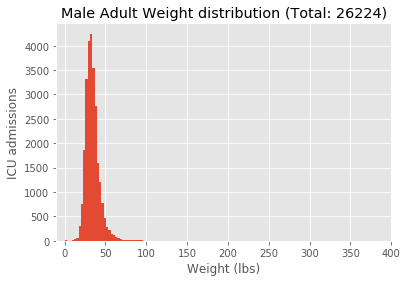

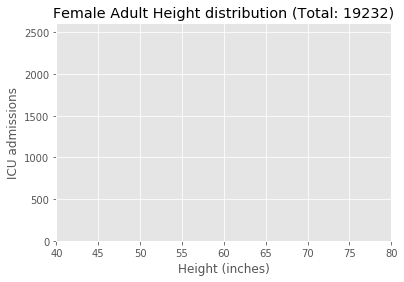

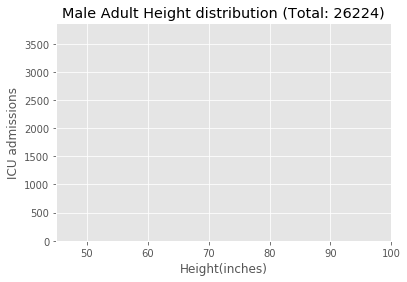

In [178]:
t_df = df[(df['icustay_age_group'] == 'adult') & (df['gender'] == 'F')]
t_df['w_first'].hist(bins=100)
plt.xlim(-10,400)
plt.xlabel('Weight (lbs)')
plt.ylabel('ICU admissions')
plt.title('Female Adult Weight distribution (Total: %d)' % len(t_df))
plt.show()

t_df = df[(df['icustay_age_group'] == 'adult') & (df['gender'] == 'M')]
t_df['w_first'].hist(bins=100)
plt.xlim(-10,400)
plt.xlabel('Weight (lbs)')
plt.ylabel('ICU admissions')
plt.title('Male Adult Weight distribution (Total: %d)' % len(t_df))
plt.show()

t_df = df[(df['icustay_age_group'] == 'adult') & (df['gender'] == 'F')]
t_df['h_first'].hist(bins=100)
plt.xlim(40,80)
plt.xlabel('Height (inches)')
plt.ylabel('ICU admissions')
plt.title('Female Adult Height distribution (Total: %d)' % len(t_df))
plt.show()

t_df = df[(df['icustay_age_group'] == 'adult') & (df['gender'] == 'M')]
t_df['h_first'].hist(bins=100)
plt.xlim(45,100)
plt.xlabel('Height(inches)')
plt.ylabel('ICU admissions')
plt.title('Male Adult Height distribution (Total: %d)' % len(t_df))
plt.show()

In [179]:
# Let's find the AUC for SAPS for each racial group

def get_auc(score, expire):
    fpr, tpr, thresholds = roc_curve(expire, score)
    return auc(fpr, tpr)

df['icu_expire_bool'] = df['icustay_expire_flag'] == 'Y'

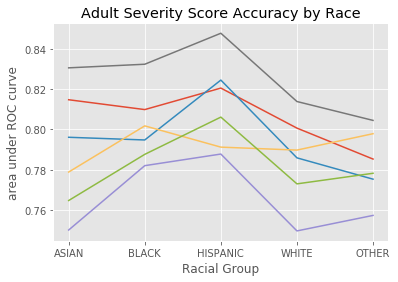

In [180]:
# HERE IT IS:  race
target_df = df[df['icustay_age_group'] == 'adult']

sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

plt.figure()
for ss in sev_scores:
#     print ss
    s_lst = []
    for r in rlst + ['OTHER']:
        r_df = target_df[target_df['eth_group'] == r]
        auc_score = get_auc(r_df[ss], r_df['icu_expire_bool'])
        s_lst.append(auc_score)
#         print '%s: %.4f' % (r, auc_score)
#     print
    
    plt.plot(range(len(s_lst)), s_lst, label=ss)
#     plt.title(ss)
    plt.xticks(range(len(s_lst)), rlst + ['OTHER'])
#     plt.ylim(min(s_lst)*0.9,max(s_lst) * 1.1)
plt.title('Adult Severity Score Accuracy by Race')
plt.xlabel('Racial Group')
plt.ylabel('area under ROC curve')
plt.show()

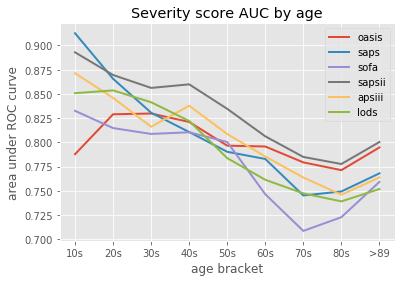

In [181]:
# Observation: severity scores are less accurate over age
target_df = df

age_lst = ['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '>89']
sev_scores = ['oasis', 'saps', 'sofa', 'sapsii', 'apsiii', 'lods']

scores = []

for ss in sev_scores:
    s_tmp = []
#     print ss
    for r in age_lst:
        r_df = target_df[target_df['age_group'] == r]
        auc_score = get_auc(r_df[ss], r_df['icu_expire_bool'])
#         print '%s: %.4f' % (r, auc_score)
        s_tmp.append(auc_score)
#     print
    scores.append(s_tmp)

plt.figure()
for s,sv in zip(scores,sev_scores):
    plt.plot(range(len(age_lst)),s, label=sv, lw=2)

plt.title('Severity score AUC by age')
plt.xlabel('age bracket')
plt.ylabel('area under ROC curve')
plt.xticks(range(len(age_lst)), age_lst)
plt.legend()
plt.show()

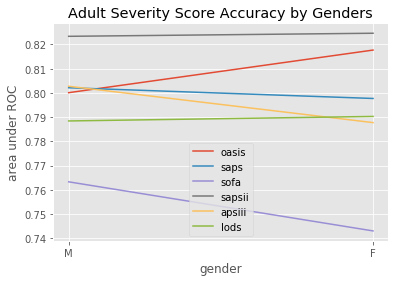

In [188]:
# HERE IT IS: gender
genders = ['M', 'F']

plt.figure()
for ss in sev_scores:
#     print ss
    s_lst = list()
    for r in genders:
        r_df = df[df['gender'] == r]
        auc_score = get_auc(r_df[ss], r_df['icu_expire_bool'])
        s_lst.append(auc_score)
#         print '%s: %.4f' % (r, auc_score)
#     print
    plt.plot(range(len(s_lst)), s_lst, label=ss)
plt.title('Adult Severity Score Accuracy by Genders')
plt.xticks(range(len(s_lst)), genders)
plt.xlabel('gender')
plt.ylabel('area under ROC')
plt.legend()
plt.show()

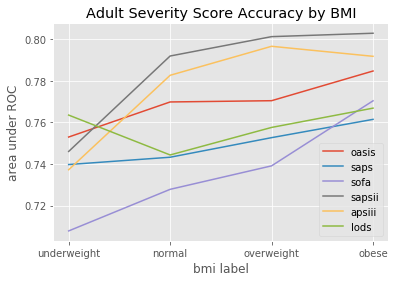

In [187]:
# AUC for BMI
genders = ['underweight', 'normal', 'overweight', 'obese']

plt.figure()
for ss in sev_scores:
#     print ss
    s_lst = list()
    for r in genders:
        r_df = df[(df['bmi_group'] == r) & (df['icustay_age_group'] == 'adult')]
        auc_score = get_auc(r_df[ss], r_df['icu_expire_bool'])
        s_lst.append(auc_score)
#         print '%s: %.4f' % (r, auc_score)
#     print
    plt.plot(range(len(s_lst)), s_lst, label=ss)
plt.title('Adult Severity Score Accuracy by BMI')
plt.xticks(range(len(s_lst)), genders)
plt.xlabel('bmi label')
plt.ylabel('area under ROC')
plt.legend()
plt.show()

In [46]:
# HERE IT IS: age group
genders = ['neonate', 'adult', '>89']

for ss in sev_scores:
    print ss
    for r in genders:
        r_df = df[df['icustay_age_group'] == r]
        auc_score = get_auc(r_df[ss], r_df['icu_expire_bool'])
        print '%s: %.4f' % (r, auc_score)
    print

oasis
neonate: 0.7782
adult: 0.7943
>89: 0.7834

saps
neonate: 0.8174
adult: 0.7853
>89: 0.7600

sofa
neonate: 0.8978
adult: 0.7553
>89: 0.7538

sapsii
neonate: 0.8352
adult: 0.8145
>89: 0.7938

apsiii
neonate: 0.7955
adult: 0.7864
>89: 0.7541

lods
neonate: 0.8949
adult: 0.7708
>89: 0.7454



### Appendix

In [19]:
# Moment of truth: how accurate is each test on each demographic?

query = query_schema + """
WITH ALL_SCORES as (
    SELECT 
        ie.subject_id, ie.hadm_id, ie.icustay_id,
        ie.intime, ie.outtime, adm.deathtime,
        pat.gender, adm.ethnicity,
        ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) AS age,
        ROUND((cast(ie.intime as date) - cast(adm.admittime as date))/365.242, 2) AS preiculos,
        CASE
            WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 1
                THEN 'neonate'
            WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) <= 14
                THEN 'middle'
            -- all ages > 89 in the database were replaced with 300
            WHEN ROUND((cast(ie.intime as date) - cast(pat.dob as date))/365.242, 2) > 100
                THEN '>89'
            ELSE 'adult'
            END AS ICUSTAY_AGE_GROUP,
        CASE
            WHEN adm.discharge_location = 'DEAD/EXPIRED' THEN 'Y'
            ELSE 'N'
            END AS hospital_expire_flag,
        CASE
            WHEN adm.deathtime BETWEEN ie.intime and ie.outtime
                THEN 'Y'
            -- sometimes there are typographical errors in the death date, so check before intime
            WHEN adm.deathtime <= ie.intime
                THEN 'Y'
            WHEN adm.dischtime <= ie.outtime
                AND adm.discharge_location = 'DEAD/EXPIRED'
                THEN 'Y'
            ELSE 'N'
            END AS ICUSTAY_EXPIRE_FLAG,
        os.oasis, sf.sofa, sp.saps
    FROM icustays ie
    INNER JOIN patients pat
    ON ie.subject_id = pat.subject_id
    INNER JOIN admissions adm
    ON ie.hadm_id = adm.hadm_id
    INNER JOIN oasis os
    on ie.hadm_id = os.hadm_id
    INNER JOIN sofa sf
    on ie.hadm_id = sf.hadm_id
    INNER JOIN saps sp
    on ie.hadm_id = sp.hadm_id
)
SELECT 
    ethnicity, COUNT(1) as num_patients, 
    AVG(oasis) as oasis_avg, AVG(sofa) as sofa_avg, AVG(saps) as saps_avg, 
    AVG(CASE WHEN hospital_expire_flag = 'Y' THEN 1 ELSE 0 END) * 100 as per_hos_expire,
    AVG(CASE WHEN ICUSTAY_EXPIRE_FLAG = 'Y' THEN 1 ELSE 0 END) * 100 as per_icu_expire
from all_scores
group by ethnicity
"""
racial_groups = pd.read_sql_query(query, con)
racial_groups.head()

,ethnicity,num_patients,oasis_avg,sofa_avg,saps_avg,per_hos_expire,per_icu_expire
0,BLACK/HAITIAN,189,29.603175,3.248677,15.121693,11.111111,2.645503
1,BLACK/AFRICAN AMERICAN,12866,29.519509,4.824110,17.607726,14.176900,5.090937
2,HISPANIC/LATINO - GUATEMALAN,54,26.370370,2.611111,16.074074,1.851852,0.000000
3,HISPANIC OR LATINO,3591,28.610136,4.406015,16.151211,23.475355,6.850459
4,ASIAN,2491,25.621437,3.559615,14.235247,14.853473,6.382979


In [34]:
racial_groups['eth_group'] = racial_groups['ethnicity'].apply(get_racial_group)

In [36]:
racial_groups.groupby('eth_group').sum()['num_patients']

eth_group
ASIAN         3930
BLACK        13483
HISPANIC      4377
OTHER        22736
WHITE       111010
Name: num_patients, dtype: int64

In [ ]:
racial_groups['eth_group'] = racial_groups['ethnicity'].apply(get_racial_group)

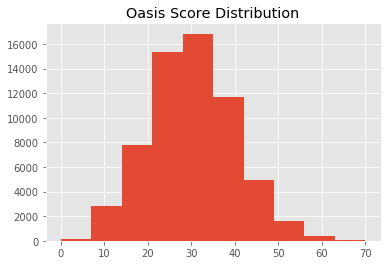

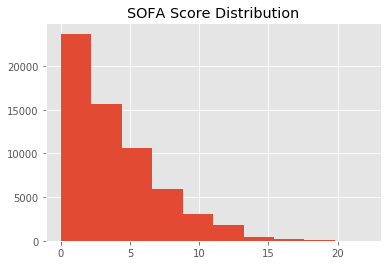

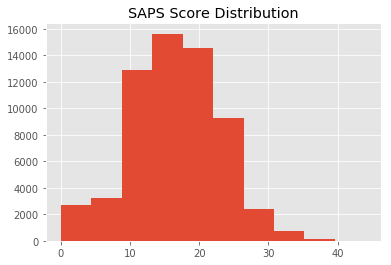

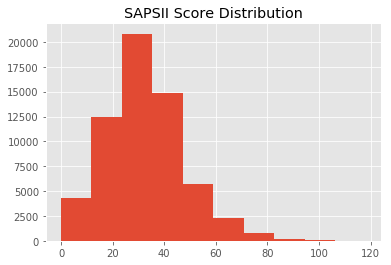

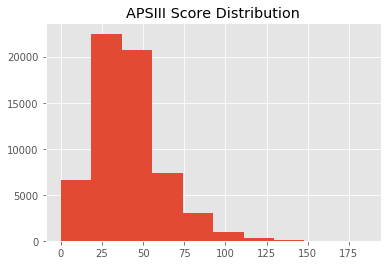

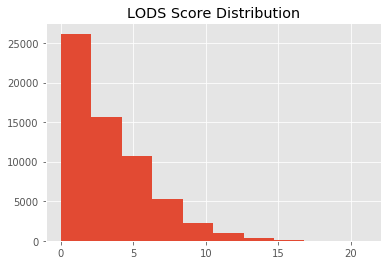

In [75]:
plt.hist(df.oasis)
plt.title('Oasis Score Distribution')
plt.show()

plt.hist(df.sofa)
plt.title('SOFA Score Distribution')
plt.show()

plt.hist(df.saps)
plt.title('SAPS Score Distribution')
plt.show()

plt.hist(df.sapsii)
plt.title('SAPSII Score Distribution')
plt.show()

plt.hist(df.apsiii)
plt.title('APSIII Score Distribution')
plt.show()

plt.hist(df.lods)
plt.title('LODS Score Distribution')
plt.show()

Considerations to take into mind:
* service? exclude surgery?
* 